In [32]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import math
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

Implementation of classes:
AbstarctFeatureToNumericTransformer, LevelToNumericTransformer, BinaryToNumericTransformer, CyclicalToNumericTransformer,QualitativeToNumericTransformer - classes which allow to transform features to numeric

OutlierCorrector - class allows to detect outliers and replace outliers 
NanTransformer - class allows to detect Nan values and replace Nan

In [33]:
#Transformer to Numeric
class AbstarctFeatureToNumericTransformer:
    def __init__(self, name_of_features):
        self.name_of_features=name_of_features
        
    def fit(self, x, y=None):
        self.name_of_features = [f for f in self.name_of_features if f in x.columns]
        return self 
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        raise NonImplemented("the method is not implemented, instatiate a child class")
        return
     
class LevelToNumericTransformer(AbstarctFeatureToNumericTransformer):
    def __init__(self,name_of_level_features,order_of_level_features):
        super().__init__(name_of_level_features)
        self.order_of_level_features=order_of_level_features
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for l,o in zip(self.name_of_features, self.order_of_level_features):
            mask=pd.isna(x[l])
            mask=np.logical_not(mask)
            x[l][mask]=pd.Categorical(x[l][mask], categories=o, ordered=True).codes
        return x


class BinaryToNumericTransformer(AbstarctFeatureToNumericTransformer):
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for l in self.name_of_features:
            mask=pd.isnull(x[l])
            mask=np.logical_not(mask)
            x[l][mask]=pd.Categorical(x[l][mask],ordered=True).codes
        return x


class CyclicalToNumericTransformer(AbstarctFeatureToNumericTransformer):
     def transform(self,x:pd.DataFrame):
        x=x.copy()
        for c in self.name_of_features:
            y_i=np.sin(2*np.pi*x[c]/np.max(x[c]))
            x_i=np.cos(2*np.pi*x[c]/np.max(x[c]))
            x=x.drop(columns=c)
            dx = pd.DataFrame(list(x_i),columns =[c+'_x'])
            dy = pd.DataFrame(list(y_i),columns =[c+'_y'])
            x.reset_index(drop=True, inplace=True)
            x=pd.concat([x,dx,dy], axis=1)
        return x

class QualitativeToNumericTransformer(AbstarctFeatureToNumericTransformer):
    def __init__(self,name_of_level_features,category_names):
        super().__init__(name_of_level_features)
        self.category_names=category_names
    def qualitative_features_to_one_hot(self,feature, categories, data):
        data = pd.Categorical(data, categories = categories)
        #data=data.astype(str)
        one_hot = pd.get_dummies(data)
        new_header={col:feature+'_'+str(col) for col in list(one_hot.columns)}
        one_hot.rename(columns = new_header, inplace = True)
        one_hot.drop(columns=one_hot.columns[0], axis=1, inplace=True)
        return one_hot
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for feature, cat_name in zip(self.name_of_features, self.category_names):
            one_hot=self.qualitative_features_to_one_hot(feature, cat_name, x[feature])
            x.reset_index(drop=True, inplace=True)
            x=pd.concat([x, one_hot], axis=1)
            x=x.drop(columns=[feature])
        return x

#Outliers Correction
class OutlierCorrector:
    def __init__(self, quantitative_features=[], level_features=[],p_value = 0.05):
        self.level_features=level_features
        self.quantitative_features=quantitative_features
        self.p_value=p_value

    def calculate_mean(self, feature, mask_o):
        mask_nan=pd.isnull(feature)
        mask=np.logical_and(~mask_o,~mask_nan)
        mean=feature[mask].mean()
        return mean
    
    def normal_correction(self, feature):
        std=feature.std()
        mean=feature.mean()
        min=mean-3*std
        max=mean+3*std
        mask_min=feature<min
        mask_max=feature>max
        mask=np.logical_or(mask_min, mask_max)
        mean=self.calculate_mean(feature, mask)
        return min,max,mean
    
    def calculate_median(self, feature, mask_o):
        mask_nan=pd.isnull(feature)
        mask=np.logical_and(~mask_o,~mask_nan)
        median=feature[mask].median()
        return median
    
    def non_normal_correction(self, feature):
        Q1 = feature.quantile(0.25)
        Q3 = feature.quantile(0.75)
        IQR = Q3 - Q1
        min=Q1 - 1.5 * IQR
        max=Q3 + 1.5 * IQR
        mask_min=feature<min
        mask_max=feature>max
        mask=np.logical_or(mask_min, mask_max)
        median=self.calculate_median(feature,mask)
        return min,max,median
    
    def fit(self, x, y=None):
        self.min={}
        self.max={}
        self.replace={}
        for feature in self.level_features+self.quantitative_features:
            mask=x[feature].isnull()    
            a,b=stats.shapiro(x[feature][~mask])
            if b<=self.p_value:
                min,max,replace=self.non_normal_correction(x[feature])
            else:
                min,max,replace=self.normal_correction(x[feature])
            if feature in self.level_features:
                replace=round(replace)
            
            self.min[feature]=min
            self.max[feature]=max
            self.replace[feature]=replace     
        return self
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        for feature in self.level_features+self.quantitative_features:
            min=self.min[feature]
            max=self.max[feature]
            mask_min=x[feature]<min
            mask_max=x[feature]>max
            mask_o=np.logical_or(mask_min, mask_max)
            mask_nan=pd.isnull(x[feature])
            mask=np.logical_and(mask_o,~mask_nan)
            x[feature][mask]=self.replace[feature]
        return x

# Nan Transformer
class NanTransformer:
    def __init__(self, qualitative_features=[], quantitative_features=[], cyclical_features=[], 
                 binary_features=[],level_features=[], p=600):
        self.p=p
        self.qualitative_features=qualitative_features
        self.quantitative_features=quantitative_features
        self.cyclical_features=cyclical_features
        self.binary_features=binary_features
        self.level_features=level_features
        
    def find_dropped_features(self,x):
        null_values=pd.isnull(x)
        count_null_values=null_values.sum(axis=0)
        mask_null_values_more_than_p=count_null_values>self.p
        features=np.array(list(x.columns))
        dropped_features=features[mask_null_values_more_than_p.values]
        return dropped_features
    
    def find_features_with_outliers(self):
        mask_null_values_less_than_or_equal_p=count_null_values<=self.p
        mask_null_values_more_than_0=count_null_values>0
        mask_null_values=np.logical_and(mask_null_values_less_than_or_equal_p,mask_null_values_more_than_0)
        header_series_contains_null_values=list(x.columns)
        features_contain_null_values=header_series_contains_null_values[mask_null_values.values]
        return features_contain_null_values
    
    def get_median(self,feature):
        mask=feature.isnull().values
        m=feature[np.logical_not(mask)].median()
        return m

    def get_mode(self,feature):
        feature=feature.copy()
        feature.fillna("Empty")
        m=feature.mode().values[0]
        return m

    def fit(self, x, y=None):
        self.dropped_features= self.find_dropped_features(x)
        self.qualitative_features=[feature for feature in self.qualitative_features if feature not in self.dropped_features]
        self.binary_features=[feature for feature in self.binary_features if feature not in self.dropped_features]
        self.level_features=[feature for feature in self.level_features if feature not in self.dropped_features]
        self.cyclical_features=[feature for feature in self.cyclical_features if feature not in self.dropped_features]
        self.quantitative_features=[feature for feature in self.quantitative_features if feature not in self.dropped_features]
        
        self.replace={}
        for feature in self.binary_features+self.cyclical_features+self.qualitative_features:
            r=self.get_mode(x[feature])
            self.replace[feature]=r
        
        for feature in self.quantitative_features:
            r=self.get_median(x[feature])
            self.replace[feature]=r
            
        for feature in self.level_features:
            r=self.get_median(x[feature])
            self.replace[feature]=round(r)
        return self
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        x=x.drop(columns=self.dropped_features)
        for feature in self.binary_features+self.cyclical_features+self.qualitative_features+self.quantitative_features+self.level_features:
            m=self.replace[feature]
            x[feature][x[feature].isna()] = m
        return x

Reading data into dataframe
Division features into several groups. Level features and satisfaction features are all most the same group. Satisfaction features include numbers (e.g from 1 to 5). Level feature after transformation will also include numbers.
y - class
x - fetaures
Division x on x_train, x_test and y on y_train, y_test
Pipeline includes transformation to numeric values, outliers and Nan transformation, data normalization and classification process
Data from file train.csv were divided into train and test datasets.

In [34]:
path='C:\\Dokumenty\\Nowa praca\\train_airplane.csv'
df = pd.read_csv(path)

y=df["satisfaction"]
binary_features=["Gender","Customer Type","Type of Travel"]
level_features=["Class"]
satisfaction_features=["Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking","Gate location",
                      "Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service",
                      "Leg room service","Baggage handling", "Checkin service","Inflight service", "Cleanliness"]
quantitative_features=["Age","Flight Distance","Departure Delay in Minutes","Arrival Delay in Minutes"]
cyclical_features=[]

df=df.drop(columns=['Unnamed: 0', 'id',"satisfaction"])
header=list(df.columns)
qualitative_features=[el for el in header if el not in binary_features+level_features+quantitative_features+satisfaction_features]

feature_value_orders=[['Eco','Eco Plus','Business']]
feature_value_categories=[[]]

x=df
y.replace("satisfied",1,inplace=True)
y.replace("neutral or dissatisfied",0,inplace=True)
y=y.values


#division x on x_train, x_test and y on y_train, y_test
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
p_value=0.05
p=50000
pipe=Pipeline([['LevelToNumericTransformer', LevelToNumericTransformer(level_features,feature_value_orders)],
               ['OutlierCorrector', OutlierCorrector(quantitative_features, level_features+satisfaction_features,p_value)],
               ['NanTransformer',NanTransformer(qualitative_features, quantitative_features, cyclical_features,
                                binary_features, level_features+satisfaction_features, p)],
               ['BinaryToNumericTransformer', BinaryToNumericTransformer(binary_features)],
               ['QualitativeToNumericTransformer',QualitativeToNumericTransformer(qualitative_features, feature_value_categories)],
               ['CyclicalToNumericTransformer',CyclicalToNumericTransformer(cyclical_features)],
               ['ScaleSacaler', StandardScaler()],
               ["LR",LogisticRegression()]])
#KNeighborsClassifier
#KNeighborsClassifier(n_neighbors=3)
pipe.fit(x_train, y_train)
y_pred=pipe.predict(x_test) 

        

Confusion matrix
Accuracy, F1, recall,
Roc curve

Metrix
Confusion matrix
[[10716  1131]
 [ 1510  7424]]
Accuracy
0.8729127568451951
F1
0.8489907942135057
recall
0.8309827624804119


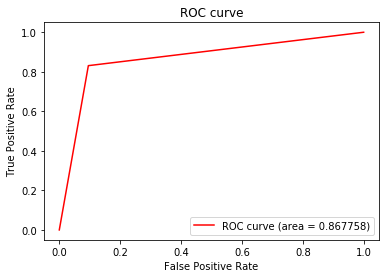

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Metrix')
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cm)
ac=accuracy_score(y_test, y_pred)
print('Accuracy')
print(ac)
f1=f1_score(y_test, y_pred)
print('F1')
print(f1)
recall=recall_score(y_test, y_pred)
print('recall')
print(recall)


fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(
    fpr,
    tpr,
    color="red",
    label="ROC curve (area = %f)" % roc_auc,
)
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC curve')
plt.show()

Importance of weights 
Bar plot shows weight for each feature.

Text(0,0.5,'Weight of feature')

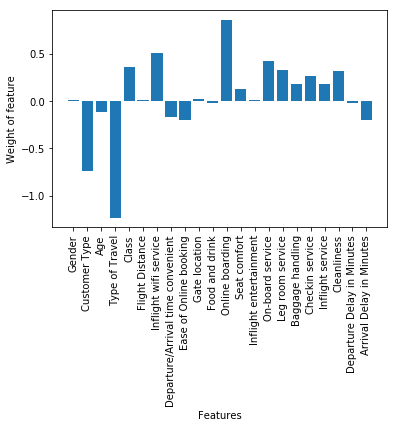

In [36]:
pipe_new_before_scaler=Pipeline(pipe.steps[:-2])
x_train_before_scaled=pipe_new_before_scaler.transform(x_train)
features=x_train_before_scaled.columns
weights_of_features=pipe.named_steps['LR'].coef_[0]
plt.bar(features,weights_of_features)
plt.xticks(features,rotation=90)
plt.xlabel('Features')
plt.ylabel('Weight of feature')

Cross validation - 5 fold cross validation
x_train and y_train are divided into 5 parts.
4 parts are used in learning process and 1 part is for validation
Each part from 5 is used for validation so the process is repeated 5 time.
We obtain 5 accuracies.

In [37]:
from sklearn.model_selection import KFold
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
acc=[]
for x_train_index, x_valid_index in KFold(5).split(x_train):
    x_train_k=x_train.values[x_train_index,:]
    x_train_k=pd.DataFrame(x_train_k, columns=x_train.columns)
    x_valid_k=x_train.values[x_valid_index,:]
    x_valid_k=pd.DataFrame(x_valid_k, columns=x_train.columns)
    y_train_k=y_train[x_train_index]
    y_valid_k=y_train[x_valid_index]
    pipe.fit(x_train_k, y_train_k)
    y_pred=pipe.predict(x_valid_k)
    ac=accuracy_score(y_valid_k, y_pred)
    acc.append(ac)
print(acc)
y_pred=pipe.predict(x_test)
ac=accuracy_score(y_test, y_pred)
print('Accuracy')
print(ac)

[0.8706766917293233, 0.8736842105263158, 0.872421052631579, 0.8742179980750722, 0.8730149181905679]
Accuracy
0.8777248448101631


class FeatureSelection which allows to decrease the numebr of features

In [38]:
class FeatureSelection:
    def __init__(self,w):
        self.w=w
        
    def fit(self, x, y=None):
        x_train=x
        y_train=y
        pipe=Pipeline([['ScaleSacaler', StandardScaler()],
                      ["LR",LogisticRegression()]]) 
        pipe.fit(x_train, y_train)
        features=x_train.columns
        weights=np.abs(pipe.named_steps['LR'].coef_[0])
        
        weights_index=np.argsort(weights)
        self.features=np.array(features)[weights_index[:self.w]]
        return self
    
    def fit_transform(self, x, y=None):
        self.fit(x,y)
        return self.transform(x)
    
    def transform(self,x:pd.DataFrame):
        x=x.copy()
        x=x.drop(columns=self.features)
        return x


Pipeline with Feature Selection, 200 repetitions, mean and std of F1

In [39]:
#division x on x_train, x_test and y on y_train, y_test
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
p_value=0.05
p=50000
w=5
pipe=Pipeline([['LevelToNumericTransformer', LevelToNumericTransformer(level_features,feature_value_orders)],
               ['OutlierCorrector', OutlierCorrector(quantitative_features, level_features+satisfaction_features,p_value)],
               ['NanTransformer',NanTransformer(qualitative_features, quantitative_features, cyclical_features,
                                binary_features, level_features+satisfaction_features, p)],
               ['BinaryToNumericTransformer', BinaryToNumericTransformer(binary_features)],
               ['QualitativeToNumericTransformer',QualitativeToNumericTransformer(qualitative_features, feature_value_categories)],
               ['CyclicalToNumericTransformer',CyclicalToNumericTransformer(cyclical_features)],
               ['FeatureSelection', FeatureSelection(w)],
               ['ScaleSacaler', StandardScaler()],
               ["KNN",KNeighborsClassifier(n_neighbors=3)]])
f1=[]
for i in range(30):
    x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
    pipe.fit(x_train, y_train)
    y_pred=pipe.predict(x_test) 
    f1_s=f1_score(y_test, y_pred)
    f1.append(f1_s)
print('F1 score, 200 repetitions: ')
print(np.mean(f1))
print(np.std(f1))
    

F1 score, 200 repetitions: 
0.9196047623691991
0.002290830767641845
